In [1]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [2]:
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class RouteResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")


def supervisor_agent(state):
    supervisor_chain = (
            prompt
            | llm.with_structured_output(RouteResponse)
    )
    return supervisor_chain.invoke(state)

In [4]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

In [5]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

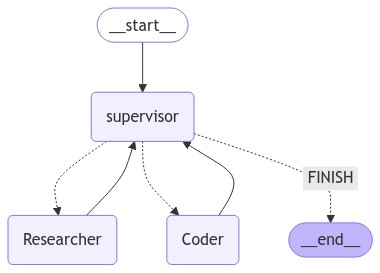

In [6]:
from langchain_core.runnables.graph import CurveStyle
from IPython.display import Image, display

display(
    Image(graph.get_graph(xray=True).draw_mermaid_png(curve_style=CurveStyle.BASIS, output_file_path='image/06Supervision.png')))

In [7]:
for s in graph.stream(
        {
            "messages": [
                HumanMessage(content="Code hello world and print it to the terminal")
            ]
        }
):
    # if "__end__" not in s:
    print(s)
    print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='The code to print "Hello, World!" to the terminal is:\n\n```python\nprint(\'Hello, World!\')\n```\n\nWhen executed, it produces the output:\n\n```\nHello, World!\n```', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [6]:
for s in graph.stream(
        {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
        {"recursion_limit": 100},
):
    # if "__end__" not in s:
    print(s)
    print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### Research Report on Pikas\n\n#### Overview and Characteristics\n\nPikas, small mammals belonging to the family Ochotonidae, are closely related to rabbits and hares. Unlike their larger relatives, pikas are notable for their small, round bodies, short limbs, and lack of a visible tail. They typically weigh between 125 and 200 grams and measure approximately 15 centimeters in length. Their fur is soft, long, and thick, usually brownish or reddish in color.\n\n#### Habitat and Distribution\n\nPikas are primarily found in rocky, mountainous regions across North America and Asia. In these habitats, they often dwell among talus slopes and rock fields. Some Asian species, however, inhabit burrows. Because pikas do not hibernate, they remain active throughout the winter by traveling in tunnels under rocks and snow, feeding on dried plants that they have stored.\n\n#### Foraging and Diet\n\nPikas 

APIConnectionError: Connection error.